In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 1. Factor Investing in Fixed Income Credit - Background  

## 1.1. What is Factor Investing?

Factor investing is about investing in securities featuring certain characteristics that have proved to deliver higher risk-adjusted returns than the market over time, following a fixed set of rules. In other words, it is based on the systematic exploitation of a number of premiums, called factor premiums, that have shown to be robust over time and across different markets.

Factor investing can be **viewed as a third way of investing** somewhere in between the traditional active/discretionary approach (where portoflio managers are supposed to deliver excess/active return over market benchmarks) and passive strategies (just delivering the market return, without taking additional risks). 
<div>
<img src="https://i.ibb.co/9Gf4gTS/Picture3.png" width = "350"/>
</div>

In recent years, active managers have been criticized over how much value (alpha) they actually add relative to the fees they charge. That has led to strong growth in passive managers which are closely following a pre-determined market index for just a fraction of the cost of active management. What factor investing is trying to achieve is delivering the active return of discretionary managers in a rule-based and transparent way (similar to passive managers) by **offering investors a systematic exposure to well-documented factor premiums while still charging them much lower fees than active investors**. 

## 1.2. Short history of Factor Investing

**Factor premiums have been extensively documented in academic literature for over four decades.** Prior to the 1960s, investors had very little understanding of the relationship between the risk and return of their investments. This changed with the development of the Capital Asset Pricing Model, or CAPM, which assumes a linear and positive relationship between risk and return – greater risk should lead to higher return – and the possibility to optimize a portfolio’s return-risk profile on a curve called the efficient frontier (the so-called Markowitz Portfolio Theory). 

**By the middle of the 1980s, it was becoming clear that a number of factors other than market risk needed to be considered**, and alternative models were developed. One of the most famous was the three-factor model developed in the early 1990s by future Nobel prize laureate Eugene Fama and fellow researcher Kenneth French. Their model, which essentially extended the CAPM, assumed that a stock’s average returns were strongly related to its **size (market capitalization) and valuation (book-to-market ratio)**, not just to its market exposure.

While Fama and French’s three-factor model quickly became one the most influential models, many other studies suggested that more than three factors are needed to accurately explain stock returns. In 1997, for example, Mark Carhart proposed **adding a momentum factor** to the Fama-French model. In 2015, Fama and French responded to these studies by adding two additional factors to their model: profitability and investment. The combination of the two is often referred to as **the quality factor**. 

## 1.3. Most common factors

Nowadays, there are dozens of market premiums and anomalies that have been reported in the academic literature – but just a small number of factors have been thoroughly tested in practice.  

**Value** - the tendency of inexpensive securities, relative to their fundamentals, to outperform over the longer term.

**Momentum** - the tendency of securities that have performed well in the recent past to continue to perform well, and for securities that have performed poorly to continue to perform poorly.

**Low risk** - refers to the observation that low-risk securities tend to earn higher risk-adjusted returns than high-risk securities.

**Quality** - the tendency of securities issued by sound and profitable companies to outperform those issued by less sound and profitable companies, and the market as a whole.

**Size** - the tendency of bonds issued by companies with little debt outstanding and small-capitalization stocks to outperform the market.

## 1.4. The growth of Fixed Income (FI) Factor Investing

Although factors were initially discovered in the stock market, these premiums can also be found in most asset classes, including bonds, currencies and commodities. In fact, **factor investing can be applied both within and across multiple asset classes**.

Over the years, the number of academic studies showing that factor investing can also be applied to fixed income rose dramatically, as large historical data sets on individual bonds (one of the early impediments) became more widely available. There are two academic papers that are perceived as fundamental to the recent growth of interest in Fixed Income Factor Investing, both done by practitioners rather than academia: 

-	**Factor Investing in the Corporate Bond Market (2016)** by Patrick Houweling and Jeroen van Zunder from Robeco Asset Management (we refer to this paper as just “Robeco paper” in this project)
-	**Common Factors in Corporate Bond Returns (2018)** - Ronen Israela, Diogo Palharesa and Scott Richardson from AQR Asset Management (we refer to this paper as just “AQR paper” in this project)

In 2020, the leading global provider of market indices, **MSCI, has launched the first FI Factor Indices**. This is likely to further push the development of the market as passive and smart-beta investors can now launch products that closely track these indices. 

# 2. Project aim and specifications

We believe that Machine Learning can be successfully implemented in the growing area of FI Factor Investing. Its powerful algorithms and common practices can provide us with an enchanced framework for deriving the factors that depend on multiple variables. 

## 2.1. Starting point

The following table summarizes the exact approaches to FI factor development and backtesting by the above-mentioned three main information sources:
<div>
<img src="https://i.ibb.co/LRX6ts8/Capture.jpg"/>
</div>
 
As we can see, **some of the factors can be easily defined by applying readily available market data to a single variable**:
- Carry is defined by the Option Adjusted Spread (OAS)
- Size by the total amount of debt issued by the company
- Momentum by the 6-month prior returns 

These are areas where ML can be of no real use. 

**More interesting are the Quality, Low risk & Value factors**. We have to say that there is some overlapping (and high historical correlation) between the Low Risk and Quality factor - AQR instead is using the so-called "Defensive" factor that combines their characteristics. The lack of consensus and the fact that little can be done for researching the Quality factor without access to company's financial/accounting data – which we do not have at the moment - leave us with no much choice but to **concentrate our efforts on the Value factor**. But it is also the most interesting and challenging factor. 

##  2.2. What is Value? 

Value factor is the tendency for relatively cheap assets to outperform relatively expensive ones. One security is perceived to have a "value" if its current "market value" is below the one justified by its fundamentals (their "fair value"). If that is the case, it is considered to be "cheap". On the opposite side are the "expensive" securities traded at market values above their "fair" value. In stock markets, the "market value" is determined by the market capitalization of the company (price * stocks issued) - while the fair value is usually determined by companies earnings (Price to Earnings ratio) or assets (Price to Book Value ratio). 

In bond markets things are more complicated as each company usually have numerous securities issued, each with its own characteristics like duration, liquidity, and sometimes different credit ratings, that ultimately makes them to differ in their risk profile - even if issued by the very same company. So we cannot have a single "market value" for an issuer that can just be compared to its "fair value". Instead, we make the comparisons on a bond level.

**To construct a value signal, we need a market value measure (price, yield, spread..), a fundamental/fair value measure and an approach to compare the two**. In the papers that we reviewed, the chosen approach is always based on the residuals from a cross-sectional regression that uses the Option-adjusted Spread (OAS) as a market value measure (i.e. dependent variable) - but different indicators for "fair value" (i.e. independent variables):
-	MSCI - Duration, Size & Rating
-	Robeco – Rating, Time to Maturity & 3-month OAS Spread change
-	AQR (Empirical) – Duration, Rating & Excess return Volatility

The goal of the regression is to make a relevant comparison between bonds with similar but not identical characteristics. It is an assessment of average market required compensation for the bond’s fundamental risk levels. Individual bond value is then measured as the deviation of the OAS from its fitted value from the model. Bonds with high positive deviations are deemed to be cheap versus those with similar characteristics. Conversely, bonds with high negative deviations are deemed to be expensive. Here is a good visualization of this approach, comparing OAS to just one risk factor - average life of the bond:

<div>
<img src="https://i.ibb.co/MGb9Shh/picture-5.png"/, width = 450>
</div>


## 2.3. How we define Value 

Instead of pre-defined approach to determine Value, we will let our Machine Learning algorithms to find the best model that fits our bond universe - while generalizing well on unseen data. By doing this, we hope we can provide **a more robust approach to Value than the one based on a simple linear regression by**:
- accounting for non-linear relationships between the explanatory variables and the target variable (OAS)
- providing "educated guess" just for the possible set of explanatory variables - but not the ones that will be part of the final model (that will be decided by the Machine Learning algorithms)

**What is the possible set of explanatory variables?** Combining all three approaches to Value by MSCI, Robeco & AQR, we can define the set as follows:
1. Duration (MSCI & AQR)
2. Time to Maturity (Robeco)
3. Issuer Size (MSCI)
4. Credit Rating (MSCI, AQR & Robeco)
5. Default Probability (AQR) 
6. 3-month OAS change (Robeco)
7. Excess Return Volatility (AQR)

Since we dont have access to historical data, we cannot include the last two variables. Default probability is also based on accounting & equity market data (the Merton model for Distance to default) so we have to skip it for the moment. Also, the duration of a bond is almost perfectly correlated to its time to maturity - and since the former is used by two of the three papers, we prefer to use duration only. Lastly, we add another possible explanatory factor to our model, "age percent", which could serve as a proxy for illiquidity of a bond  - this is the third key risk factor for corporate bonds, along with the term structure (measured by duration) and probability of default (measured by credit rating). 

## 2.4. Final inputs to our project 

**Target/Dependent Variable**: 

**Option Adjusted Spread (OAS)** – This is the spread (i.e. the difference in basis points) between the market yield of a corporate bond (which bears a credit risk, or risk of default, and liquidity risk) and the risk-free rate (The US Treasury which return is perceived as riskless and are the most liquid bond instruments). It is adjusted for any embeded optionalities in the bonds, hence the OAS in the name. 
We work with both Investment Grade (IG, perceived as less risky) and High Yield (HY, riskier) corporate bonds.
<div>
<img src="https://i.ibb.co/H2BPQNR/credit-risk.jpg"/, width = 350>
</div>

**Features/Independent Variables**:

- **Credit Rating** (as measured by the rating agencies) - better rating means lower default risk, which is the ultimate driver of credit spreads (especially for High Yield bonds)


- **Duration** - also known as "spread duration" in the case of corporate bonds, it is an indicator of bond's sensitivity to changes in credit spreads (i.e. credit volatility) - the longer the duration (i.e. the weighted average time of receiving its cash flows), the higher is the uncertainty and the bond sensitivity to market changes. It is the main credit risk indicator for IG bonds where the default risk is insignificant and investors are mostly concerned with credit volatility.


- **Issue size** - smaller bonds tend to be traded at higher relative spreads due to their lower liquidity (they are more expensive to trade)


- **Age percent** - measures the time passed since the bond was issued as percent of its original maturity (i.e. how aged it is) - as newly issued bonds tend to be more liquid, it serves as a proxy for illiquidity


Once we have a proper ML model for deriving the Value factor, we have to becktest it over a significant historical period. If this backtest proves that the model is robust over time, **it can be used to define an investment strategy that tries to exploit this Value premium - either on a stand-alone basis (as Value strategy) or in combination with the other FI factors (as Multi-factor strategy)**

# 3. Investment Universe - Selection Process

As we already mentioned, data availability is one of the big issues with Fixed Income Credit research. Our choice of dataset for this project is based on what we already have at our disposal, without paying for additional services. Probably the best one is an excel file with all bonds available on the Bloomberg platform on 12th of March 2019. Lets read the file first:

In [2]:
all_data = pd.read_csv("bonds_data.csv")
all_data.head()

,id,amount_outstanding,rating,country_of_risk,coupon_type,currency,date,duration,sector,issue_date,maturity,maturity_type,payment_rank,oas_spread,is_covered
0,AP254159 Corp,4.415500e+09,N.A.,BJ,FIXED,XOF,12/03/2019,NaN,Government,22/09/2017,22/09/2027,AT MATURITY,Unsecured,NaN,False
1,AS344473 Corp,2.191670e+10,N.A.,BJ,FIXED,XOF,12/03/2019,NaN,Government,27/04/2018,27/04/2021,AT MATURITY,Unsecured,NaN,False
2,AX052804 Corp,2.200000e+10,N.A.,BJ,FIXED,XOF,12/03/2019,NaN,Government,25/01/2019,25/01/2022,AT MATURITY,Unsecured,NaN,False
3,LW638292 Corp,1.500000e+11,N.A.,BJ,FIXED,XOF,12/03/2019,NaN,Government,29/06/2016,29/06/2023,AT MATURITY,Unsecured,NaN,False
4,AR676438 Corp,1.774850e+10,N.A.,BJ,FIXED,XOF,12/03/2019,NaN,Government,16/03/2018,16/03/2021,AT MATURITY,Unsecured,NaN,False


In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293986 entries, 0 to 293985
Data columns (total 15 columns):
id                    293986 non-null object
amount_outstanding    276036 non-null float64
rating                293986 non-null object
country_of_risk       293986 non-null object
coupon_type           293986 non-null object
currency              293986 non-null object
date                  293986 non-null object
duration              169611 non-null float64
sector                293986 non-null object
issue_date            293885 non-null object
maturity              290525 non-null object
maturity_type         293986 non-null object
payment_rank          293986 non-null object
oas_spread            175657 non-null float64
is_covered            293986 non-null bool
dtypes: bool(1), float64(3), object(11)
memory usage: 31.7+ MB


In [4]:
# set id as index:
data = all_data.set_index("id")

We have to apply numerous criteria to this dataset in order to make it comparable to the typical Investment Universe used in the research papers and by bond practitioners - which is based on bond indices with few thousand liquid securities, usually part of a well-known bond index. In the case of AQR, for example, they work with 600 IG and 700 HY USD bonds coming from Bank of America Merrill Lynch Indexes. 

To achieve this similarity, the following criteria is applied to our dataset:
- **currency** - including USD bonds only, which is the largest, most developed and widely used bond universe (including the research papers). We can use EUR bonds (the second largest and most developed) as a separate dataset. Mixing currency is not recommended due to the different pricing applied by the market across currencies.
- **sector** - excluding Government, Financial & Diversified bonds, thus focusing on non-financial Corporates
- **coupon** - including Fixed, Zero-Coupon & Step-Coupons
- **maturity_type** - including Bullets ("AT MATURITY"), Callable, Putable & Sinkable
- **rating** - including Investment Grade ("AAA","AA+","AA","AA-","A+","A","A-","BBB+","BBB","BBB-") & High Yield ("BB+","BB","BB-","B+","B","B-","CCC+","CCC","CCC-")
- **amount_outstanding** - minimum 300mln for IG and minimum 150mln for HY (Bloomberg Indices method)
- **oas_spread** - including bonds with positive oas_spread and below 1000bps (cutting outliers where spread cannot be explained by the common market indicators that we use in this project) 

Since we select only bonds with ratings, we do not need to apply additional criteria for "is_covered" (whether the bond is covered by specific assets) or "payment_rank" (rank in issuer's capital structure - crucial in case of default) as these differences in credit risk between bonds are already reflected in their ratings. 

In [5]:
currency_criteria = data.currency == "USD"
sector_criteria = (data.sector != "Government") & (data.sector != "Financial") & (data.sector != "Diversified")
coupon_criteria = (data.coupon_type == "FIXED") | (data.coupon_type == "ZERO COUPON") |(data.coupon_type == "STEP CPN")
maturity_type_criteria = (data.maturity_type == "AT MATURITY") | (data.maturity_type == "CALLABLE") | (data.maturity_type == "PUTABLE") | (data.maturity_type == "SINKABLE")
ratings_IG = ["AAA","AA+","AA","AA-","A+","A","A-","BBB+","BBB","BBB-"]
ratings_HY = ["BB+","BB","BB-","B+","B","B-","CCC+","CCC","CCC-"]
amount_criteria = ((data.amount_outstanding > 300000000) & (data.rating.isin(ratings_IG))) | ((data.amount_outstanding > 150000000) & (data.rating.isin(ratings_HY)))
spread_criteria = (data.oas_spread >0) & (data.oas_spread <1000)

In [6]:
data = data[currency_criteria][sector_criteria][coupon_criteria][maturity_type_criteria][amount_criteria][spread_criteria]

C:\Users\petko\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7794 entries, EI108597 Corp to AT608718 Corp
Data columns (total 14 columns):
amount_outstanding    7794 non-null float64
rating                7794 non-null object
country_of_risk       7794 non-null object
coupon_type           7794 non-null object
currency              7794 non-null object
date                  7794 non-null object
duration              7793 non-null float64
sector                7794 non-null object
issue_date            7794 non-null object
maturity              7794 non-null object
maturity_type         7794 non-null object
payment_rank          7794 non-null object
oas_spread            7794 non-null float64
is_covered            7794 non-null bool
dtypes: bool(1), float64(3), object(10)
memory usage: 860.1+ KB


# 4. Pre-processing Data

Our next job is to convert the date columns into datetime and derive two very important bond indicators:
- **time_to_maturity** - measures the remaining time to maturity of a bond and will allow us to apply one more criteria needed - working with bonds with at least 1 year to maturity (important to minimize transaction costs)
- **age_percent** - the last feature of our model

In [8]:
data.date, data.issue_date, data.maturity = pd.to_datetime(data.date), pd.to_datetime(data.issue_date), pd.to_datetime(data.maturity)

In [9]:
data["time_to_maturity"] = ((data.maturity - data.date)/np.timedelta64(1, "Y")).round(2)
data = data[data.time_to_maturity > 1]
data["age_percent"] = (data.date - data.issue_date) / (data.maturity - data.issue_date)

We can now drop the columns that we dont need anymore - **leaving us with the main explanatory variables for credit spreads: credit rating, duration, issue size & age_percent** 

Lastly, we can also **convert the credit rating categories to numerical values** - starting from 1 (stongest credit, "AAA") and ending at 19 (weakest credit, "CCC-"). This approach (instead of creating dummy variables) is fine since the categories are hierarchical and we want to explore the effect of this hierarhy on credit spreads. This is the approach to ratings also by MSCI & AQR (while Robeco runs the Value regression on rating dummies).

In [10]:
data = data.drop(["maturity_type", "is_covered", "coupon_type", "date", "currency", "country_of_risk", "sector","payment_rank","issue_date", "maturity", "time_to_maturity"], axis = 1)

In [11]:
rating_dict = {"AAA":1, "AA+":2, "AA":3, "AA-":4, "A+":5, "A":6, "A-":7, "BBB+":8, "BBB":9, "BBB-":10, "BB+":11, "BB":12,
               "BB-":13, "B+":14, "B":15, "B-":16, "CCC+":17, "CCC":18, "CCC-":19}
data.rating = data.rating.map(rating_dict).astype("int64")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6859 entries, AS375105 Corp to AT608718 Corp
Data columns (total 5 columns):
amount_outstanding    6859 non-null float64
rating                6859 non-null int64
duration              6858 non-null float64
oas_spread            6859 non-null float64
age_percent           6859 non-null float64
dtypes: float64(4), int64(1)
memory usage: 321.5+ KB


In [12]:
#drop missing values which are insignificant % of our dataset (just 1)
data = data.dropna()

In [13]:
#rename some columns
data.rename(columns = {"amount_outstanding" : "issue_size", "oas_spread": "spread"}, inplace = True)

In [14]:
#convert to millions
data.issue_size = data.issue_size/1000000

# 5. Explanatory Data Analysis

Before rescaling & splitting our dataset, lets first get more familiar with it.

In [15]:
#basic statistical profile
data.describe().round(2)

,issue_size,rating,duration,spread,age_percent
count,6858.00,6858.00,6858.00,6858.00,6858.00
mean,842.33,9.37,6.87,205.07,0.41
std,689.96,3.41,4.65,154.54,0.23
min,156.63,1.00,0.01,0.35,0.00
25%,495.78,7.00,3.28,106.46,0.22
50%,600.00,9.00,5.25,163.18,0.37
75%,1000.00,11.00,10.60,258.66,0.59
max,15000.00,19.00,22.79,994.76,0.96


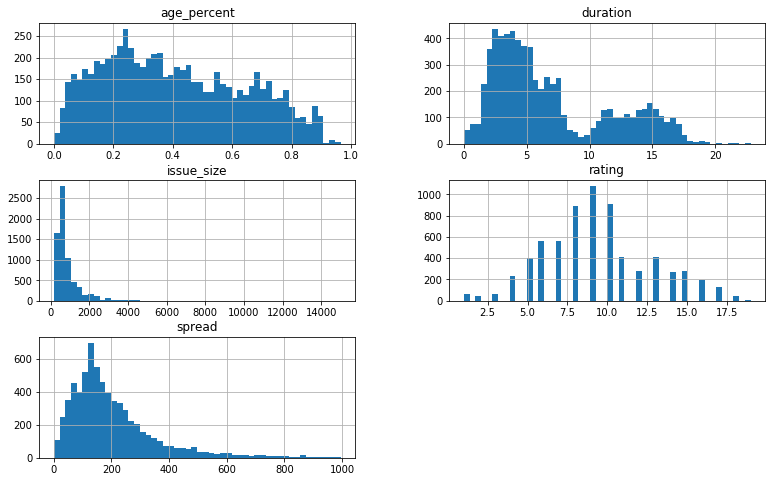

In [16]:
#distribution shapes
data.hist(bins=50, figsize=(13,8))
plt.show()

In [17]:
#how much each feature correlates with the spread
data.corr()["spread"].round(2).sort_values(ascending = False)

spread         1.00
rating         0.74
duration      -0.01
issue_size    -0.07
age_percent   -0.13
Name: spread, dtype: float64

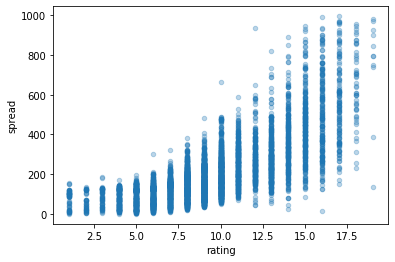

In [18]:
#visualize the high linear relationship
data.plot(kind="scatter", x="rating", y="spread",alpha=0.3)
plt.show()

In [19]:
#check for multicolinearity between features
data.corr().round(2)

,issue_size,rating,duration,spread,age_percent
issue_size,1.00,-0.10,0.07,-0.07,-0.08
rating,-0.10,1.00,-0.39,0.74,0.14
duration,0.07,-0.39,1.00,-0.01,-0.69
spread,-0.07,0.74,-0.01,1.00,-0.13
age_percent,-0.08,0.14,-0.69,-0.13,1.00


**Few important observations from the charts above:**
- issue_size is highly negatively skewed with some large outliers, also duration to some extend
- rating has very high correlation to the spread (0.74) while the remaining variables has very small linear relationship with the dependent variable
- there is a strong negative linear relationship between age_percent & duration (-0.69)

# 6. Data Transformations

At first glance, issue_size and duration are two variables that look very suitable for lognormal transformation. This is also the approach seen in some of the papers when deriving their Value factor (MSCI to duration & size and AQR to duration & OAS). 

Another possibility is to standardize the dataset and winsorize it at +/- 3 standard deviations. This is our prefered approach - and also the one that MSCI applies when deriving the final scores for all its Fixed Income Factor indices.

In [20]:
#define function for standardization plus winsorizing at +/- st.dev
def standardize_winsorize(data):
    data = ((data - data.mean())/data.std()).clip(3,-3)
    return data

In [21]:
#tranform the explanatory variables only
features = ["age_percent", "duration", "issue_size", "rating"]
for feature in features:
    data[feature] = standardize_winsorize(data[feature])

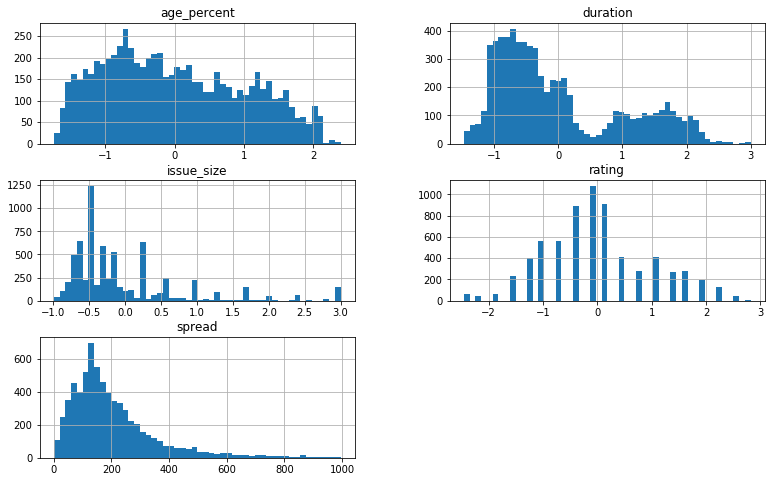

In [22]:
#compare the new transformed distributions to the old ones
data.hist(bins=50, figsize=(13,8))
plt.show()

# 7. Data Split

Before proceeding with the real Machine Learning, we should first split our data in an appropriate way - which will allow us to **1) train our model (training set), 2) select the best model (validation set) and 3) test the best model on a completely new data (test set)**. Validation sets are important part of the Machine Learning model selection - they allow us to evaluate several candidate models and select the best one. After this validation, we can train the best model on the full training set (including the validation set) which will give us the final model. Lastly, we evaluate this final model on the test set to get an estimate of the generalization error.

Our cleaned dataset contains 6858 observations - which is fairly small by Machine Learning standards. Still, it should be large enough to apply the standard 60/20/20 split (train/validaiton/test) and still being assured that the law of large numbers will remain valid when evaluating our models with **1372 observations in the validation & test sets**. 

When splitting, we would like to be sure that our training dataset is unbiased and contains enough observations from each rating - the feature with the highest correlation to our dependent variable. Hence, we stratify the split by this column.

In [23]:
features = data.drop("spread", axis = 1)
target = data.spread.copy()
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.20, random_state = 42, stratify = data.rating)
train_features, validation_features, train_target, validation_target = train_test_split(train_features, train_target, test_size=0.25, random_state = 42, stratify = train_features.rating)
#check the shapes of each dataset
len(train_features), len(validation_features), len(test_features), len(train_target), len (validation_target), len(test_target)

(4114, 1372, 1372, 4114, 1372, 1372)

# 8.  Models Training & Selection

## Selecting a performance measure

Before proceeding with the model selection, we should first define the criteria by which we are going to do it - i.e. the performance measure of our model. 

The default option in sklearn library for regression models is R squared (the explained variance by the model as percent of the total variance in the data) but the one mostly used for regression problems is the Root Mean Square Error (RMSE). It gives us an idea of how much error the model typically makes in its predictions (i.e. the average difference between the actual and predicted values for our target variable), with a higher weight for large errors (due to the square). 

In other words, RMSE is the standard deviation of the model residuals. This makes it the perfect measure for our task - as defined in the beginning of the object, we are explicitly interested in the residuals of the model (positive ones -> cheap bonds/large Value factor). Since our strategy would be based on their value, **we want to be sure that the model:**

- is robust and correctly approximates the relationships in the data -> **low RMSE**

- any residuals from it are just random noise (i.e. mispriced by the market) -> **randomness in the residual plot**


## 8.1. Linear Regression

We start with the standard multiple regression model.

In [24]:
#create an empty DataFrame to keep the results of our trained alogrithms
model_results = pd.DataFrame(columns = ["Model", "RMSE train", "RMSE test"])

In [25]:
#define an universal function for model fitting, scoring & plotting
def fit_score_plot(model, train_features, train_target, test_features, test_target, coef = False, plot = False, name = ""):
    
    model.fit(train_features, train_target)
    train_predictions = model.predict(train_features)
    test_predictions = model.predict(test_features)
      
    #calculate our performance measure - RMSE
    rmse_train = np.sqrt(mean_squared_error(train_target, train_predictions)).round(2)
    rmse_test = np.sqrt(mean_squared_error(test_target, test_predictions)).round(2)
    
    #append the scores to our DataFrame
    model_results.loc[len(model_results.index)] = {"Model": f"{name}", "RMSE train": rmse_train, "RMSE test": rmse_test}
    
    #print the scores to get an idea of model performance
    print(name, "RMSE train:", rmse_train)
    print(name, "RMSE test:", rmse_test)
    if coef:
        if model == lr:
            print("Model coefficients:", model.intercept_.round(2), sorted(zip(model.coef_.round(2), train_features.columns), reverse = True))
        else:
            print("Feature importances:", sorted(zip(model.feature_importances_.round(2), train_features.columns), reverse = True))
    if plot:
        plt.scatter(test_predictions, test_target, alpha = 0.3)
        y_lim = plt.ylim(-200,1000)
        x_lim = plt.xlim(-200,1000)
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        plt.plot(x_lim, y_lim, 'k-', color = 'r')
        plt.xlabel('Predicted Spread')
        plt.ylabel('Actual Spread')
        plt.title(f"{name} Actual vs Predicted")
        plt.show()
        
        plt.scatter(test_predictions, test_target - test_predictions, alpha = 0.3)
        plt.axhline(y=0, linestyle='--', color = "r")
        plt.ylabel('Residuals')
        plt.xlabel('Predicted Spread')
        plt.title(f"{name} Residuals Plot")
        plt.show()

In [26]:
lr = LinearRegression()

LR RMSE train: 94.98
LR RMSE test: 93.12
Model coefficients: 205.36 [(131.92, 'rating'), (42.35, 'duration'), (-2.41, 'issue_size'), (-9.22, 'age_percent')]


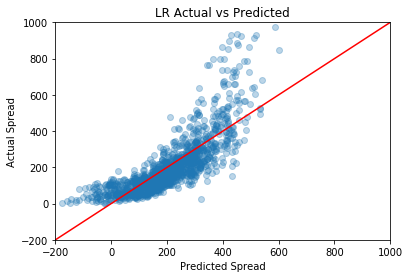

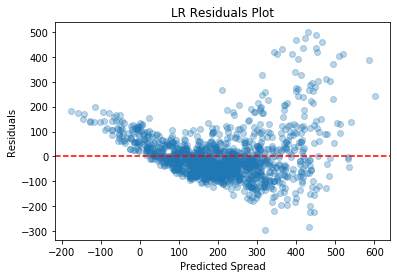

In [27]:
fit_score_plot (lr, train_features, train_target, validation_features, validation_target, coef = True, plot = True, name = "LR")

From our EDA earlier we know that the typical spread is in the range of 105 and 260 bps (the interquartile range), so a typical prediction error of around 93bps is not very satisfying. It is a typical sign of a model underfitting our data. 

When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

According to this linear model, most of the low spreads (between 0 and 100bps) and almost all of the high spreads (above 400 bps) are cheap (above the red line) while most of the medium spreads (between 100bps and 400bps) are expensive (above the red line). 

The LR model clearly fails to capture the non-linear realtionship between the features and the target variable - while the residual plot also looks correlated with the predicted spread, indicating for a poor fit.

**What can we do about this underfitting?**
- select a more powerful model
- feed the training algorithm with better features
- reduce the constraints on the model (not valid here since our model has not been regularized)

Lets first try to increase the power of our model and capture any non-linearities and dependencies between the features by performing a polynomial regression.

## 8.2. Polynomial Regression

The Polynomial Regression is a more complex model that can fit non-linear datasets. It is still based on the Linear Regression model but feeds the algorithm with exponentially more features (depending on the polynomial degree we choose - the hyperparameter) by adding powers of each feature and all possible combinations of features up to the given degree. 
It can easily lead to explosion in our number of features (the so-called Curse of Dimensionality) so here we start with just a second-degree Polynomial Regression for a quick check on the explanatory power of the model.

In [28]:
poly_transformer = PolynomialFeatures(degree=2)
#transform the features for train and validation
poly_train_features = poly_transformer.fit_transform(train_features)
poly_val_features = poly_transformer.fit_transform(validation_features)
#check the dimensionality increase
poly_train_features.shape

(4114, 15)

Poly LR RMSE train: 80.78
Poly LR RMSE test: 77.63


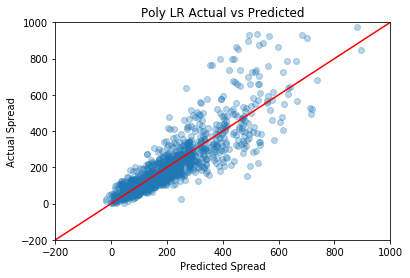

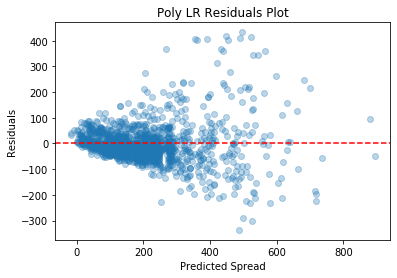

In [29]:
fit_score_plot (lr, poly_train_features, train_target, poly_val_features, validation_target, plot = True, name = "Poly LR")

We see that our RMSE on the test set dropped substantially to 78bps from 93bps and is just slighly lower than the RMSE on the train set (a signal that there is no overfitting despite the increased complexity of the model) indicating that this transformation is indeed improving our model.

The charts also look more promising - with much more randomness. **We should definetely shortlist the Polynomial LR as one of our best models.**

In [30]:
model_results

,Model,RMSE train,RMSE test
0,LR,94.98,93.12
1,Poly LR,80.78,77.63


## 8.3. Decision Trees & Random Forests

**Decision Trees are powerful Machine Learning algorithms** where the data is continuously split according to a certain parameter. They are doing it by repeatedly scanning over the various explanatory factors and choosing the factor that delivers the greatest variance reduction. 

The tree can be explained by two entities, namely decision nodes and leaves. The leaves are the decisions or the final outcomes. And the decision nodes are where the data is split.

<div>
<img src="https://i.ibb.co/GJ4W3sK/Picture1.png" width = "350"/>
</div>

**Left without any constraints (i.e. no regularization), Decision Trees are prone to overfitting** as they can fit the training data perfectly, learning both the underlying conditions adn the noise in the data. That makes their predictions very sensitive even to small changes in the training data. In machine learning language, a single decision tree would probably have a low bias in its predictions (i.e. the model is flexible enough to generate predicitons close to the actual values) but also a high variance (predictions vary greatly from one training dataset to another). 

<div>
<img src="https://i.ibb.co/p01hJtB/Picture2.png" width = "300"/>
</div>

**Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms available today**. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. That makes the model less sensitive to noise in the original data (i.e. less prediction variance). 

This method is called the wisdom of the crowd and building a model on top of many other models is called Ensemble Learning - often a great way to push ML algorithms even further.

Yet another great quality of Random Forests is that they **make it easy to measure the relative importance of each feature**. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce variance on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

Lets check few Random Forest Regressors (with different number of trees, or "n_estimators") to see how they perform. 

In [31]:
#default settings - n_estimators = 100
rfr = RandomForestRegressor(random_state = 42)
fit_score_plot (rfr, train_features, train_target, validation_features, validation_target, coef=True, name = "RF")

RF RMSE train: 29.67
RF RMSE test: 76.61
Feature importances: [(0.63, 'rating'), (0.22, 'duration'), (0.08, 'age_percent'), (0.07, 'issue_size')]


In [32]:
#random forests with 1 tree -i.e Decision Tree
rfr1 = RandomForestRegressor(n_estimators = 1, random_state = 42)
fit_score_plot (rfr1, train_features, train_target, validation_features, validation_target, coef=True, name = "RF1")

RF1 RMSE train: 63.71
RF1 RMSE test: 111.74
Feature importances: [(0.63, 'rating'), (0.23, 'duration'), (0.07, 'age_percent'), (0.06, 'issue_size')]


RF5 RMSE train: 39.94
RF5 RMSE test: 83.06
Feature importances: [(0.63, 'rating'), (0.22, 'duration'), (0.08, 'age_percent'), (0.07, 'issue_size')]


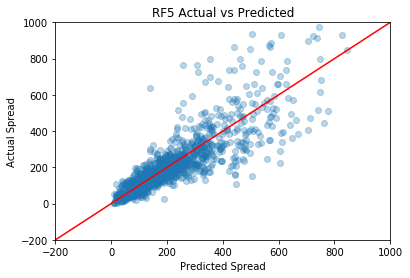

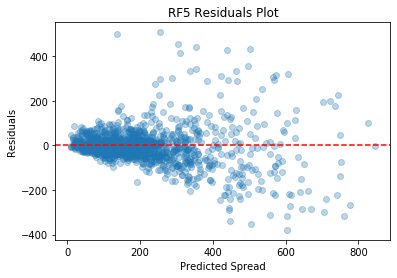

In [33]:
#random forest with decision trees
rfr5 = RandomForestRegressor(n_estimators = 5, random_state = 42)
#visualize the overfitting
fit_score_plot (rfr5, train_features, train_target, validation_features, validation_target, coef=True, plot = True, name = "RF5")

In [34]:
model_results

,Model,RMSE train,RMSE test
0,LR,94.98,93.12
1,Poly LR,80.78,77.63
2,RF,29.67,76.61
3,RF1,63.71,111.74
4,RF5,39.94,83.06


As we can see from the graphs, Random Forests look very promising and we should select them for further improvement and testing. However, **the scores on the training set are much lower than on the validation sets, meaning that the model is badly overfitting the training set**. Possible solutions for overfitting are:
- simplify the model
- constrain it (i.e., regularize it)
- get a lot more training data

The last option is not valid for our project, so we concentrate our efforts on simplification & regularization.

# 9. Models Fine-tuning & Improvements

So far, we selected Polynomial Regression & Random Forests as our best models. Lets see how we can improve them before selecting the final one for testing.

## 9.1. Polynomial Regression
### 9.1.1. K-fold Cross Validation

Our polynomial regression looks promising , so lets explore more options. That usually means playing with the hyperparameters of the model - in the case of Poly LR the most important one is the maximum degree of the polynomials used. 

**We combine this search for a better polynomial regression with K-fold cross-validation**. This is a better evalation method for models with not very large datasets, like ours. K-fold cross-validation randomly splits the training set into K distinct subsets called folds, then it trains and evaluates the model K times, picking a different fold for evaluation every time and training on the other K-1 folds. The result is an array containing the K evaluation scores.

*An important note here is that Scikit-Learn’s cross-validation function (cross_val_score) expects a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why we use (-scores) before calculating the square root below.*

In [36]:
#polynomial degrees to explore - up to 9
degrees = np.arange(2,10)
for degree in degrees:
    
    poly_transformer = PolynomialFeatures(degree = degree)
    poly_train_features = poly_transformer.fit_transform(train_features)
    poly_model = LinearRegression()
    poly_model.fit(poly_train_features, train_target)
    
    #cross
    scores = cross_val_score(poly_model, poly_train_features, train_target, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores).round(1)
    rmse_mean = rmse_scores.mean().round(1)
    rmse_std = rmse_scores.std().round(1)
    print("Polynomial Degree:", degree)
    print("Scores:", rmse_scores)
    print("Mean:", rmse_mean)
    print("Standard Deviation:", rmse_std)
    print("=================================================")

Polynomial Degree: 2
Scores: [85.6 84.7 76.5 78.5 79.8]
Mean: 81.0
Standard Deviation: 3.5
Polynomial Degree: 3
Scores: [85.4 82.5 75.  77.4 76.5]
Mean: 79.4
Standard Deviation: 3.9
Polynomial Degree: 4
Scores: [85.8 78.  74.2 77.3 74.1]
Mean: 77.9
Standard Deviation: 4.3
Polynomial Degree: 5
Scores: [85.5 76.4 77.  77.4 74.8]
Mean: 78.2
Standard Deviation: 3.7
Polynomial Degree: 6
Scores: [88.3 77.  89.9 79.3 76.3]
Mean: 82.2
Standard Deviation: 5.8
Polynomial Degree: 7
Scores: [163.   84.6 100.1  95.8  85. ]
Mean: 105.7
Standard Deviation: 29.3
Polynomial Degree: 8
Scores: [394.  123.2 235.2 161.5 267.5]
Mean: 236.3
Standard Deviation: 94.1
Polynomial Degree: 9
Scores: [2581.   243.2  717.4  832.8 1143. ]
Mean: 1103.5
Standard Deviation: 793.4


We can see that higher polynomial degrees are improving our mean score up to a certain point (4th degree) but the standard deviation within the scores is fluctuating. Ultimately, we would like to use a model with low mean score and low standard deviation. While in that case the 5th-degree polynomial might look as a most suitable choice, **we would go for a bit simpler model that offers us similar mean and standard deviation - the 3rd-degree.** 

It is still fairly complex model (including 35 features) - so we should definetely try to regularize it. Lets first train the model of choice on the whole training set and see how it compares to our previous models.

In [37]:
poly3_transformer = PolynomialFeatures(degree = 3)
poly3_train_features = poly3_transformer.fit_transform(train_features)
poly3_validation_features = poly3_transformer.fit_transform(validation_features)
poly3_model = LinearRegression()
poly3_model.fit(poly3_train_features, train_target)
#check dimensionality increase
poly3_train_features.shape

(4114, 35)

Poly3 LR RMSE train: 78.48
Poly3 LR RMSE test: 76.49


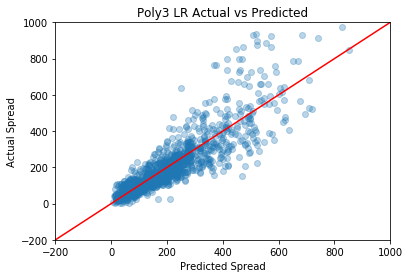

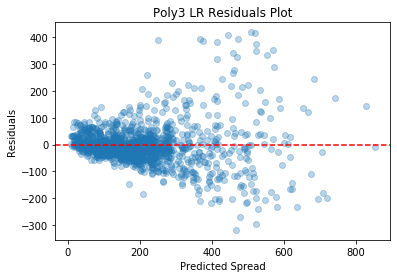

In [38]:
fit_score_plot (poly3_model, poly3_train_features, train_target, poly3_validation_features, validation_target, plot = True, name = "Poly3 LR")

In [39]:
model_results

,Model,RMSE train,RMSE test
0,LR,94.98,93.12
1,Poly LR,80.78,77.63
2,RF,29.67,76.61
3,RF1,63.71,111.74
4,RF5,39.94,83.06
5,Poly3 LR,78.48,76.49


The new Poly3 model managed to improve the RMSE test score a bit compared to the original Poly LR model - but that is at the cost of a large increase in complexity. **Lets try to reduce this large dimensionality of the model.**

### 9.1.2. Regularization

Constraining a model to make it simpler and reduce the risk of overfitting is called regularization. The amount of regularization to apply during learning can be controlled by the hyperparameters.

### Polynomial Regression with Lasso regularization

Least Absolute Shrinkage and Selection Operator Regression (simply called Lasso Regression) is a regularized version of Linear Regression. An important characteristic of Lasso Regression (and the reason we prefer it over the Ridge regression) is that it tends to completely eliminate the weights of the least important features (i.e. set them to zero). In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e. with few nonzero feature weights).

The main hyperparameter for regularization with Lasso is called "alpha" - the higher the alpha, the most feature coefficients are zero. That is, when alpha is 0, Lasso regression produces the same coefficients as a linear regression. 

We start our GridSearch with relatively high alpha, in order to ensure that it will simplify the model enough.

In [40]:
parameters = {
    "alpha": [10, 20, 100, 1000],
}
grid_search = GridSearchCV(Lasso(), param_grid = parameters, cv = 5)
grid_search.fit(poly3_train_features, train_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [10, 20, 100, 1000]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [41]:
grid_search.best_params_

{'alpha': 10}

In [42]:
len(grid_search.best_estimator_.coef_[grid_search.best_estimator_.coef_ > 0.01])

6

In [43]:
lasso_best = Lasso(alpha=10)
fit_score_plot (lasso_best, poly3_train_features, train_target, poly3_validation_features, validation_target, name = "Lasso Poly3 LR")

Lasso Poly3 LR RMSE train: 88.75
Lasso Poly3 LR RMSE test: 85.38


As we can see, our model got quite simple - just 6 features with coefficients above 0.01 - but at the same time it notably weakened the model (RMSE at 85bps). 

Lets see if another popular technique for dimensionality reduction can deliver better results.

### Principal Component Analysis (PCA) 

Principal component analysis (PCA) is by far the most popular algorithm for dimensionality reduction and feature extraction. It combines our input variables in a specific way, so then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables, thus minimizing the information loss.

As an added benefit, each of the “new” variables after PCA are all independent of one another. This is a benefit because the assumptions of a linear model require our independent variables to be independent of one another.

As an illustration of how PCA works, lets have a look at the following graph, showing us how much of our variance we can preserve (explained variance) for each reduction in dimensionality. We create it with 35 components - the number of our Poly3 features.

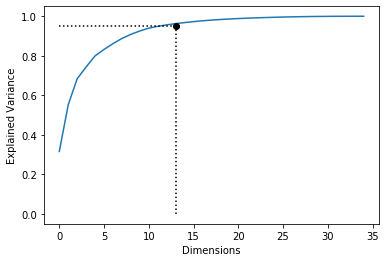

In [44]:
pca = PCA(n_components = 35)
pca.fit(poly3_train_features)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
d = np.argmax(cumsum >= 0.95) + 1
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.show()

The black point on the graph is showing us that to preserve 95% of our explained variance, we have to end up with 13 dimensions. We do not believe that our project is simple enough if we have more than 5 or 6 features - which means that we have to reduce the explained variance to around 80%. Lets see what the model would look like in that case. 

In [45]:
#try PCA with 80% explained variance
pca_80 = PCA(n_components = 0.80)
pca_80.fit(poly3_train_features)
len(pca_80.explained_variance_ratio_.round(2))

6

In [46]:
#exact explained variance with this model
np.sum(pca_80.explained_variance_ratio_).round(2)

0.83

In [47]:
#transform features for train and test
poly3_train_features_pca = pca_80.transform(poly3_train_features)
poly3_validation_features_pca = pca_80.transform(poly3_validation_features)

In [48]:
fit_score_plot (lr, poly3_train_features_pca, train_target ,poly3_validation_features_pca, validation_target, name = "PCA Poly3 LR")

PCA Poly3 LR RMSE train: 108.44
PCA Poly3 LR RMSE test: 103.98


Unfortunately, the result is even worse than the one with Lasso regularization (which also had 6 meaningful features). 

**It looks like that we cannot end up with simple yet powerful model using Polynomial features. We have to drop this model and concentrate on improving our Random Forest Regressor.**   

In [49]:
model_results

,Model,RMSE train,RMSE test
0,LR,94.98,93.12
1,Poly LR,80.78,77.63
2,RF,29.67,76.61
3,RF1,63.71,111.74
4,RF5,39.94,83.06
5,Poly3 LR,78.48,76.49
6,Lasso Poly3 LR,88.75,85.38
7,PCA Poly3 LR,108.44,103.98


## 9.2. Random Forests

### 9.2.1. Grid Search with K-fold Cross Validation

Since our RF model was clearly overfitting, the best way to regularize it is to perform a GridSearch wtih Cross Validation. Lets try to constrain it using the following hyperparameters:
- "n_estimators" - number of decision trees
- "max_depth" - represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 2 to 5 and look at the training and test errors.
- "max_features" - represents the number of features to consider when looking for the best split
- "min_samples_leaf" - the minimum number of samples required to be at a leaf node

In [50]:
rfr = RandomForestRegressor(random_state = 42)
param_grid = {
    "n_estimators": [50, 100, 200, 500, 1000],
    "max_depth": [2,3,4,5],
    "max_features": [2,3,4],
    "min_samples_leaf": [2,3,4,5]
}

grid_search = GridSearchCV(rfr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(train_features, train_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [54]:
grid_search.best_params_

{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 500}

In [56]:
best = grid_search.best_params_
max_depth, max_features, min_samples, n_estimators = best["max_depth"], best["max_features"], best["min_samples_leaf"], best["n_estimators"]
print(max_depth, max_features, min_samples, n_estimators)

5 3 3 500


In [52]:
sorted(zip(grid_search.best_estimator_.feature_importances_.round(2), train_features.columns),reverse = True)

[(0.78, 'rating'),
 (0.15, 'duration'),
 (0.04, 'issue_size'),
 (0.02, 'age_percent')]

In [76]:
#display GridSearchCV results
cv_results = grid_search.cv_results_
indicators = ["rank_test_score","mean_test_score","mean_train_score","std_test_score", "params"]
scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')[indicators].round(2)
scores_df.iloc[:,1:3] = np.sqrt(-scores_df.iloc[:,1:4]).round(2) 
scores_df.std_test_score = np.sqrt(scores_df.std_test_score).round(2)
scores_df.columns = ["rank", "mean RMSE test", "mean RMSE train", "std_test", "params"]
pd.set_option('display.max_colwidth', -1)
scores_df.head(20)

C:\Users\petko\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


,rank,mean RMSE test,mean RMSE train,std_test,params
208,1,80.02,73.62,25.99,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 500}"
209,2,80.04,73.66,26.02,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 1000}"
200,3,80.05,73.56,26.09,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 50}"
205,4,80.06,73.66,25.50,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 50}"
204,5,80.06,73.48,25.90,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 1000}"
213,6,80.07,73.85,26.17,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 500}"
218,7,80.08,74.05,26.12,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'n_estimators': 500}"
214,8,80.08,73.88,26.10,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 1000}"
203,9,80.09,73.45,25.92,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 500}"
219,10,80.11,74.09,26.10,"{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'n_estimators': 1000}"


By applying our regularization, we see that the best ranked model is not badly overfitting anymore - while just slightly worsening its score to 80 bps. 

Lets add it to our models and visualize it.  

RF best RMSE train: 74.54
RF best RMSE test: 76.0
Feature importances: [(0.78, 'rating'), (0.15, 'duration'), (0.04, 'issue_size'), (0.02, 'age_percent')]


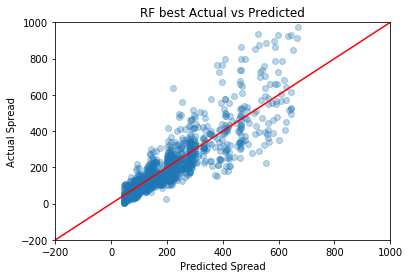

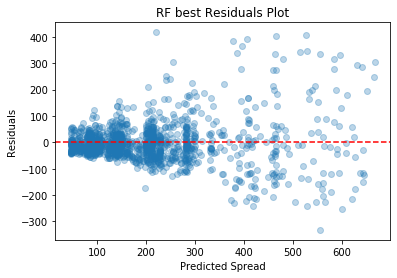

In [78]:
rf_best = RandomForestRegressor(max_depth = max_depth, max_features= max_features, min_samples_leaf = min_samples, n_estimators= n_estimators, random_state = 42)
fit_score_plot (rf_best, train_features, train_target, validation_features, validation_target, coef=True, plot = True, name = "RF best")

In [79]:
model_results

,Model,RMSE train,RMSE test
0,LR,94.98,93.12
1,Poly LR,80.78,77.63
2,RF,29.67,76.61
3,RF1,63.71,111.74
4,RF5,39.94,83.06
5,Poly3 LR,78.48,76.49
6,Lasso Poly3 LR,88.75,85.38
7,PCA Poly3 LR,108.44,103.98
8,RF best,74.54,76.00


### 9.2.2. Gradient Boosting Regressor
The general idea of Gradient Boosting is to train predictors sequentially, each trying to correct its predecessor. This method tries to fit the new predictor to the residual errors made by the previous predictor. Much like the RandomForestRegressor, this algorithm has hyperparameters to control the growth of Decision Trees (e.g.max_depth, max_features) as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators).

GradientBoostingRegressor also has a "learning rate". This hyperparameter scales the contribution of each tree. If we set the learning_rate to a low value, such as 0.1, we will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage.

In order to find the optimal number of trees, we can use early stopping. A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training.

In [80]:
gbr = GradientBoostingRegressor(max_depth = max_depth, max_features= max_features, min_samples_leaf = min_samples, n_estimators= n_estimators, random_state = 42)
gbr.fit(train_features, train_target)

errors = [mean_squared_error(validation_target, prediction) for prediction in gbr.staged_predict(validation_features)]
bst_n_estimators = np.argmin(errors)

bst_n_estimators

72

In [82]:
gbr_best = GradientBoostingRegressor(max_depth = max_depth, max_features= max_features, min_samples_leaf = min_samples, n_estimators= n_estimators,random_state = 42)

GBR best RMSE train: 34.81
GBR best RMSE test: 77.45
Feature importances: [(0.65, 'rating'), (0.2, 'duration'), (0.08, 'issue_size'), (0.07, 'age_percent')]


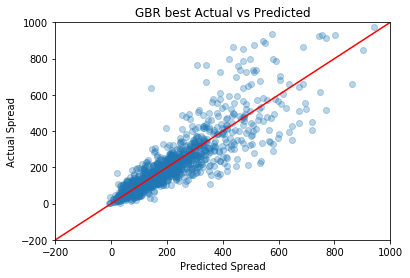

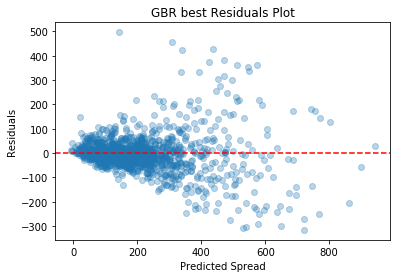

In [83]:
fit_score_plot (gbr_best, train_features, train_target, validation_features, validation_target, coef=True, plot = True, name = "GBR best")

In [84]:
model_results.sort_values(by="RMSE test")

,Model,RMSE train,RMSE test
8,RF best,74.54,76.00
5,Poly3 LR,78.48,76.49
2,RF,29.67,76.61
9,GBR best,34.81,77.45
1,Poly LR,80.78,77.63
4,RF5,39.94,83.06
6,Lasso Poly3 LR,88.75,85.38
0,LR,94.98,93.12
7,PCA Poly3 LR,108.44,103.98
3,RF1,63.71,111.74


We can see from the summary of our results that the Gradient Boosted Regressor is giving us one of the best performance measures (RMSE on the test data) - but clearly overfits the training data where the score is much smaller. 

**Evidently, our best Random Forest Regressor has the best RMSE score on the validation data and it is not signalling for overfitting. Its residual plot also looks very similar. Hence, we decide to go forward with this model.**

# 10. Final Model Evaluation on the Test Set

In [85]:
final_model = grid_search.best_estimator_

In [86]:
final_predictions = final_model.predict(test_features)
final_rmse = np.sqrt(mean_squared_error(test_target, final_predictions))
final_rmse.round(2)

73.69

Positively, our prediction error improved on the test data, showing that our final model generalize well on out-of-sample data.

We can also get an idea of how precise this estimate is by computing a 95% confidence interval for the generalization error:

In [87]:
confidence = 0.95
squared_errors = (final_predictions - test_target) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))).round(2)

array([68.04, 78.94])

Lets also check the plots of our final model.

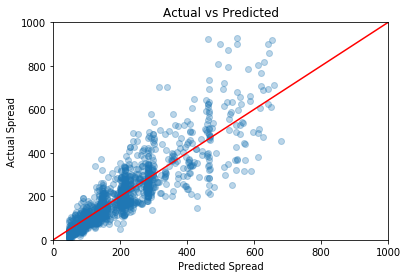

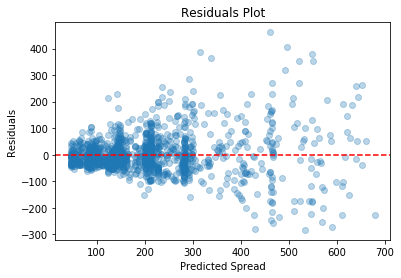

In [89]:
plt.scatter(final_predictions, test_target, alpha = 0.3)
y_lim = plt.ylim(0,1000)
x_lim = plt.xlim(0,1000)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.plot(x_lim, y_lim, 'k-', color = 'r')
plt.xlabel('Predicted Spread')
plt.ylabel('Actual Spread')
plt.title(f"Actual vs Predicted")
plt.show()
        
plt.scatter(final_predictions, test_target - final_predictions, alpha = 0.3)
plt.axhline(y=0, linestyle='--', color = "r")
plt.ylabel('Residuals')
plt.xlabel('Predicted Spread')
plt.title(f"Residuals Plot")
plt.show()

From the plots we can see that there is no clear relationship between the spread and how cheap or expensive it is according to our final model (unlike the plots from the Linear Regression in the beginning). There is enough randomness on the residual plot to **allow us to set up a strategy or test for FI Value factor based on**:
- buying cheap bonds (with large positive residual)
- selling expensive bonds (with large negative residual)

In [91]:
sorted(zip(final_model.feature_importances_.round(2), test_features.columns), reverse = True)

[(0.78, 'rating'),
 (0.15, 'duration'),
 (0.04, 'issue_size'),
 (0.02, 'age_percent')]

From feature importances above we can see that only two variables (mainly credit rating but also duration) have a real explanatory power for corporate bonds' spreads. That is giving us **a strong rationale to do an additional feature selection at this point** - and re-run our models with just two features. 

The proper way to do this is by creating a ML Pipeline that includes all the pre-processing and modelling steps done in this project. We will leave this as a future exercise and extension of the project - probably combining it with more information (accounting data, historical data) when such becomes available to the author.   

# 11. Conclusions & Further Research

In this project we tried to find a systematic way of identifying corporate bonds with Value factor characteristics by applying some of the most widely used and powerful Machine Learning techniques and algorithms. 

More specifically, we:

- pre-processed our data so it **includes only features with known explanatory power for corporate bonds spreads** - namely credit rating (i.e. default risk premium), duration (i.e. term premium) and illiquidity proxies (size & age percent)


- **standardized these features** so we can apply them in a proper way across the different algorithms (while also getting an idea of their importance in each of them); we also applied winsorizing at +/- 3 st.dev to deal with the outliers in our data 


- started our model training with **a simple Linear Regression which failed to capture the non-linearity of our data**


- tried to fix this by **applying polynomial transformations to our features** - which largely improved the performance but at the expense of more complex model with high dimensionality


- since interpretability is of crucial importance for this project, we **applied two types of regularization/dimensionality reductiuon to our Polynomial Regression - Lasso regularization and Principal Component Analysis (PCA)**; both approaches led to significantly weaker models and we decided not to proceed with Polynomial Linear Regression for our task


- also **trained an unconstrained Random Forest model** – which showed promising results but was badly overfit our training data


- tried to fix this by **applying Grid Search with K-fold Cross Validation on four different hyperparameters**; this method gave us a more solid model that is less prone to overfitting


- looked for further improvements by **training Gradient Boosting Regressor model** – which despite a bit better performance score was clearly overfitting our data

Finally, **we decided to select the best Random Forest model found by our GridSearchCV** - despite its slighly worse performance metric (RMSE) it was least prone to overfitting while being easy to interpret. The feature importances of this final model show that **credit rating is the single most powerful explanatory factor for credit spreads, followed by duration**, while our illiquidity proxies (issue size & age percent) both play insignificant roles.



### Further Research & Improvements

This project can be improved in several meaningful ways:

- **Creating a Pipeline** for automating the whole process - from receiving new data until defining the exact bonds in the strategy


- This would help us a lot in **Backtesting our Final model** - a must-do for every systematic strategy; historical monthly data is needed for at least 10 years (which prevented us from doing it within this project)


- The pipeline will be also very valuable for **applying our ML models separtely to Investment Grade & High Yield** (as done by Robeco and AQR - while MSCI considers IG bonds only for its indices) and **to a new Investment universe** (e.g. EUR corporate bonds)  


-  Acquiring historical data for backtesting would also allows us to **include other independent variables to our models** - like 3m spread change (used by Robeco) and excess return volatility (used by AQR) 


- The features can also be extended to **include accounting data**, not just market data


- This accounting data can also be used to **derive the Quality factor** for Fixed Income Credits - further extending the applications of ML in FI Factor Investing

### References:

[1] Hands-on Machine Learning with Scikit-Learn, Keras & Tensor Flow, 2nd edition (2019) - Aurelien Geron 

[2] AQR paper: Common Factors in Corporate Bond Returns (2018) - Ronen Israela, Diogo Palharesa and Scott Richardson

[3] Robeco paper: Factor Investing in the Corporate Bond Market (2016) - Patrick Houweling and Jeroen van Zunder

[4] MSCI Fixed Income Factor Indices: https://www.msci.com/our-solutions/indexes/index-profiles/fixed-income-indexes